In [1]:
#%matplotlib notebook
import numpy as np
from numpy.random import rand
from scipy.spatial import SphericalVoronoi
from matplotlib import colors
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial.distance import pdist, squareform, euclidean
import time
import pickle
from random import randint
from scipy import optimize
import copy

In [2]:
import pandas as pd

In [57]:
class BestOptimizer:
    def __init__(self, N, maxiter = 200, s = 1, idx_choice = 'cyclic', prev_energies = [], points = [], it_change = 0, alpha = 0.4, init_type = 'generalized_spiral', accelerated=False):
        self.N = N
        self.maxiter = maxiter
        self.points = np.float128(points)
        self.accelerated = accelerated
        #accelerated for Nesterov accelerated method
        self.alpha = alpha
        self.init_type = init_type
        self.Current_Energy = np.float128(0.0)
        self.it_change = it_change 
        #number of iterations after which first order method switches to second order method
        self.energies = np.float128(prev_energies)
        self.s = s #kind of kernel in Fekete problem, s=0 corresponds to log-kernel
        self.idx_choice = idx_choice
        self.H=10.0
    def init_points(self, type1):
        #Different types of sampling points on sphere
        np.random.seed(0)
        self.points = np.float128(np.zeros((self.N, 3)))
        if type1 == 'polar':
            self.points = np.float128(-1.0 + 2.0*rand(self.N, 3))
            for i in range(self.N):
                self.points[i][0] *= 0.1
                self.points[i][1] *= 0.1
                self.points[i][2] = self.points[i][0]*0.1 + 1.0
                
        elif type1 == 'uniform':
            th_phi = np.float128(rand(self.N, 2))
            self.points[:,0] = np.sin(np.pi*th_phi[:,0])*np.cos(2*np.pi*th_phi[:,1])
            self.points[:,1] = np.sin(np.pi*th_phi[:,0])*np.sin(2*np.pi*th_phi[:,1])
            self.points[:,2] = np.cos(np.pi*th_phi[:,0])
            
        elif type1 == 'equidistant':
            N = 0
            a = 4*np.pi/self.N
            d = np.sqrt(a)
            Mth = int(np.pi/d)
            dth = np.pi/Mth
            dph = a/dth
            for m in range(Mth):
                th = np.pi*(m+0.5)/Mth
                Mph = int(2*np.pi*np.sin(th)/dth)
                for n in range(Mph):
                    ph = 2*np.pi*n/Mph
                    self.points[N] = np.array([np.sin(th)*np.cos(ph), np.sin(th)*np.sin(ph), np.cos(th)])
                    N+=1
            i = 0
            for p in range(N, self.N):
                i+=1
                self.points[p] = (self.points[i] + self.points[i+1])/2.0
        elif type1 == 'generalized_spiral':
            C = 3.6
            h = np.zeros(self.N, dtype  = float)
            th = np.zeros(self.N)
            ph = np.zeros(self.N)
            for k in range(self.N):
                h[k] = -1.0+2.0*k/self.N
                th[k] = np.arccos(h[k])
                if (k!=0 and k!=self.N-1):
                    ph[k] = (ph[k-1]+C/np.sqrt(self.N+1.0)/np.sqrt(1.0-h[k]**2))%(2*np.pi)
                self.points[k] = np.array([np.sin(th[k])*np.cos(ph[k]), np.sin(th[k])*np.sin(ph[k]), np.cos(th[k])])
        else:
            pass
        for i in range(self.N):
            self.points[i] = self.points[i]/np.linalg.norm(self.points[i])
            
    def choose_alpha_Lipschitz(self, idx):
        self.Hess = self.Count_3D_Hess(idx)
        L = np.linalg.norm(self.Hess)
        self.alpha = 1.0/L
        return self.alpha
            
    def count_full_energy(self):
        energy = 0.0
        if self.s != 0:
            for i in range(self.N):
                for j in range(self.N):
                    if i > j:
                        energy += self.pairwise[i][j]**(-self.s)
            self.Current_Energy = energy
        else:
            for i in range(self.N):
                for j in range(self.N):
                    if i > j:
                        energy += -np.log(np.abs(self.pairwise[i][j]))
            self.Current_Energy = energy
        return energy
    
    def count_fix_energy(self, idx):
        #Fast count of energy and fixing pairwise matrix
        if self.s != 0:    
            for i in range(self.N):
                if i != idx:
                    self.Current_Energy -= 1.0/self.pairwise[i][idx]**self.s
        
            self.fix_point_in_pairwise(idx)
        
            for i in range(self.N):
                if i != idx:
                    self.Current_Energy += 1.0/self.pairwise[i][idx]**self.s
        else:
            for i in range(self.N):
                if i != idx:
                    self.Current_Energy -= -np.log(np.abs(self.pairwise[i][idx]))
        
            self.fix_point_in_pairwise(idx)
        
            for i in range(self.N):
                if i != idx:
                    self.Current_Energy += -np.log(np.abs(self.pairwise[i][idx]))
                    
        return self.Current_Energy
    
    def grad_point(self, idx):
        #Count gradient of a function with respect to one point, taking the rest 3N-3 variables fixed
        grad = np.zeros(3)
        if self.accelerated:
            if self.s != 0:
                for i in range(self.N):
                    if idx != i:
                        grad += -self.s*(self.points_y[idx]-self.points_y[i])/(self.pairwise_y[idx][i])**(self.s+2)
            else:
                for i in range(self.N):
                    if idx != i:
                        grad += -(self.points_y[idx]-self.points_y[i])/(self.pairwise_y[idx][i])**2
        else:
            if self.s != 0:
                for i in range(self.N):
                    if idx != i:
                        grad += -self.s*(self.points[idx]-self.points[i])/(self.pairwise[idx][i])**(self.s+2)
            else:
                for i in range(self.N):
                    if idx != i:
                        grad += -(self.points[idx]-self.points[i])/(self.pairwise[idx][i])**2

        return grad

    def delta_grad_point(self, idx):
        delta_grad = np.zeros((self.N, 3))
        if self.accelerated:
            if self.s != 0:
                for i in range(self.N):
                    if idx != i:
                        delta_grad[i] -= -self.s*(self.points_y[idx]-self.points_y[i])/(self.pairwise_y[idx][i])**(self.s+2)
                        delta_grad[i] += -self.s*(self.points_prev_y[idx]-self.points_prev_y[i])/(self.pairwise_prev_y[idx][i])**(self.s+2)
                delta_grad[idx] -= np.sum(delta_grad, axis=0)      
            else:
                for i in range(self.N):
                    if idx != i:
                        delta_grad[i] -= -(self.points_y[idx]-self.points_y[i])/(self.pairwise_y[idx][i])**2
                        delta_grad[i] += -(self.points_prev_y[idx]-self.points_prev_y[i])/(self.pairwise_prev_y[idx][i])**2
                delta_grad[idx] -= np.sum(delta_grad, axis=0)      
        else:
            if self.s != 0:
                for i in range(self.N):
                    if idx != i:
                        delta_grad[i] -= -self.s*(self.points[idx]-self.points[i])/(self.pairwise[idx][i])**(self.s+2)
                        delta_grad[i] += -self.s*(self.points_prev[idx]-self.points_prev[i])/(self.pairwise_prev[idx][i])**(self.s+2)
                delta_grad[idx] -= np.sum(delta_grad, axis=0)
            else:
                for i in range(self.N):
                    if idx != i:
                        delta_grad[i] -= -(self.points[idx]-self.points[i])/(self.pairwise[idx][i])**2
                        delta_grad[i] += -(self.points_prev[idx]-self.points_prev[i])/(self.pairwise_prev[idx][i])**2
                delta_grad[idx] -= np.sum(delta_grad, axis=0)
                                        
        return delta_grad
    
    def create_gradients(self):
        self.gradients = np.zeros((self.N, 3))
        self.tangent_grad_lengths = np.zeros(self.N)
        for i in range(self.N):
            g = self.grad_point(i)
            p = self.points[i]
            self.gradients[i] = g
            self.tangent_grad_lengths[i] = np.linalg.norm(p*np.dot(p, g) - g)
    
    def fix_gradients(self, idx):
        self.gradients += self.delta_grad_point(idx)
        for i in range(self.N):
            p=self.points[i]
            g=self.gradients[i]
            self.tangent_grad_lengths[i] = np.linalg.norm(p*np.dot(p, g) - g)
        
    def Count_3D_Hess(self, idx):
        self.Hess = np.zeros((3,3))
        if self.s != 0:
            for k in range(self.N):
                if k != idx:
                    pair_vec = self.points[idx]-self.points[k]
                    pair_dist = self.pairwise[idx][k]
                    self.Hess += self.s*(-np.identity(3)*(pair_dist**2) + (self.s+2)*np.outer(pair_vec, pair_vec))/(pair_dist**(self.s+4))
        else:
            for k in range(self.N):
                if k != idx:
                    pair_vec = self.points[idx]-self.points[k]
                    pair_dist = self.pairwise[idx][k]
                    self.Hess += (-np.identity(3)*(pair_dist**2) + 2*np.outer(pair_vec, pair_vec))/(pair_dist**4)
        
        return self.Hess
    
    def fix_point_in_pairwise(self, idx):
        for i in range(self.N):
            if i != idx:
                self.pairwise[i][idx], self.pairwise[idx][i] = (euclidean(self.points[i], self.points[idx]),)*2
                
        if self.accelerated:
            for i in range(self.N):
                if i != idx:
                    self.pairwise_y[i][idx], self.pairwise_y[idx][i] = (euclidean(self.points_y[i], self.points_y[idx]),)*2
              
    def Count_2D_Hess(self, idx):
        #3D hessian is usually indefinite with one negative eigenvalue
        #2D hessian is constructed with transition into tangent subspace
        Hess_2D = np.zeros((2,2))
        Hess_3D = copy.deepcopy(self.Hess)
        n = self.points[idx]
        Hess_2D[0][0] = Hess_3D[0][0] + Hess_3D[2][2]*(n[0]/n[2])**2 - 2*Hess_3D[0][2]*n[0]/n[2]
        Hess_2D[1][1] = Hess_3D[1][1] + Hess_3D[2][2]*(n[1]/n[2])**2 - 2*Hess_3D[1][2]*n[1]/n[2]
        Hess_2D[0][1] = Hess_3D[0][1] + Hess_3D[2][2]*n[0]*n[1]/n[2]**2 - (Hess_3D[0][2]*n[1] - Hess_3D[1][2]*n[0])/n[2]
        Hess_2D[1][0] = Hess_3D[0][1] + Hess_3D[2][2]*n[0]*n[1]/n[2]**2 - (Hess_3D[0][2]*n[1] - Hess_3D[1][2]*n[0])/n[2]
        return Hess_2D
    
    def Solve_with_Mu_Quadratic(self, A, b):
        #this is an attempt to solve a quadratic subproblem with line search
        lams, phis = np.linalg.eig(A)
        #print('lams: ', lams, phis)
        sort_idx = np.argsort(lams)
        lams=lams[sort_idx]
        phis=phis[sort_idx]
        for i in range(3):
            phis[i] /= np.linalg.norm(phis[i])
        bettas = np.dot(b,phis)
        #print('bettas: ', bettas)
        mu_u=np.linalg.norm(b)-lams[0]
        mu_l=-lams[0]+bettas[0]
        #print('mu_u: ',mu_u,'mu_l: ',mu_l)
        def func(x):
            return np.sum((bettas/(lams+x))**2)-1.0
        #res = optimize.fsolve(func, np.sqrt(3)*a[min_idx]-lams[min_idx], xtol = 1e-10)
        res = optimize.bisect(func, mu_l, mu_u, xtol = 1e-20)
        return np.dot(bettas/(lams+res),phis)
    
    def Solve_Quadratic(self, A, g, idx):
        #Quadratic subproblem solution with scipy implementation
        #Ineq constrant is equivalent to eq constraint, because A is not positive definite
        def constraint(z):
            return -(np.sqrt(np.sum(z**2)) - 1)
        point = self.points[idx]
        def f(z):
            return np.dot(0.5*np.dot(A, z-point), z-point) + np.dot(g, z-point)
        def f_reg(z):
            return np.dot(0.5*np.dot(A, z-point), z-point) + np.dot(g, z-point)# + self.H*np.linalg.norm(z-point)**3
        def jacob(z):
            return np.dot(A, z-point)+g #+3*self.H*(z-self.points[idx])*np.linalg.norm(z-self.points[idx])**2
        
        res = optimize.minimize(f, point, method="SLSQP",
                             constraints={"fun": constraint, "type": "eq"}, jac=jacob,options={'ftol': 1e-15})
        #while f(res.x/np.linalg.norm(res.x))>f(self.points[idx]):
        #    self.H=self.H*2
        #    res = optimize.minimize(f, self.points[idx], method="SLSQP",
        #                 constraints={"fun": constraint, "type": "ineq"}, jac=jacob,options={'ftol': 1e-15})
        p3 = res.x/np.linalg.norm(res.x)
        
        return p3
        
    def Gradient_descent(self):
        
        ###Choose initial position - "generalized spiral"
        if self.init_type != "continue":
            self.init_points(self.init_type)
            self.energies = np.array([])
            
        self.points = self.points[np.random.permutation(self.N)]
        
        ###Count pairwise distance matrix and count energy
        self.points_prev = copy.deepcopy(self.points)
        self.pairwise = squareform(pdist(self.points))
        self.pairwise_prev = copy.deepcopy(self.pairwise)
        
        #Accelerated
        if self.accelerated: 
            self.points_y = copy.deepcopy(self.points)
            self.pairwise_y = copy.deepcopy(self.pairwise)
            self.points_prev_y = copy.deepcopy(self.points)
            self.pairwise_prev_y = copy.deepcopy(self.pairwise)
            
        self.energies = np.append(self.energies, self.count_full_energy())
        #self.count_full_energy()
        self.energies = np.float128(self.energies)
        
        self.create_gradients() ## get self.gradients and self.tangent_grad_lengths
        self.alphas = np.zeros(self.N)
        
        for self.it in range(1, self.maxiter):
            ###Choose a point to move - one by one
            if self.idx_choice == 'prob_grad':
                prob = (self.tangent_grad_lengths**2)/sum(self.tangent_grad_lengths**2)
                idx = np.random.choice(self.N, 1, p=prob)[0]
            elif self.idx_choice == 'max_grad':
                idx = np.argmax(self.tangent_grad_lengths)
            elif self.idx_choice == 'cyclic':
                idx = self.it%self.N
            
            ###Calculate Lipschitz const and make a feasible step
            if self.it < 5*self.N or self.alphas[idx]==0:
                self.alphas[idx] = self.choose_alpha_Lipschitz(idx)
                
            if self.accelerated:
                point = self.points_y[idx] - self.alphas[idx]*self.gradients[idx]
                point/=np.linalg.norm(point)
                self.points_y[idx] = point + (self.it-1)/(self.it+2)*(point-self.points_prev[idx])
                self.points_y[idx]/=np.linalg.norm(self.points_y[idx])
                self.points_prev[idx]=point
            else:
                point = self.points[idx] - self.alphas[idx]*self.gradients[idx]
                self.points[idx] = point/np.linalg.norm(point)
            
            ###Fast count of energy and fixing pairwise distance
            self.energies = np.append(self.energies, self.count_fix_energy(idx))
            
            ###Fixing gradients, previous points and pairwise distance matrix
            self.fix_gradients(idx)
            self.points_prev = np.copy(self.points)
            self.pairwise_prev[:,idx] = self.pairwise[:,idx]
            self.pairwise_prev[idx] = self.pairwise[idx]
            
            ###Stop criterion
            if self.energies[-1] > self.energies[-2]:
                self.it_change += self.N
            if self.it > 3*self.N and np.abs(self.energies[-2*self.N] - self.energies[-1]) < 1e-10:
                break
            
        return self.energies, self.points
    
    def Newton(self):
        
        ###Choose initial position - "generalized spiral"
        if self.init_type != "continue":
            self.init_points(self.init_type)
            self.energies = np.array([])
            
        self.points = self.points[np.random.permutation(self.N)]
        
        ###Count pairwise distance matrix and count energy
        self.points_prev = copy.deepcopy(self.points)
        self.pairwise = squareform(pdist(self.points))
        self.pairwise_prev = copy.deepcopy(self.pairwise)

        self.energies = np.append(self.energies, self.count_full_energy())
        #self.count_full_energy()
        self.energies = np.float128(self.energies)
        
        self.create_gradients() ## get self.gradients and self.tangent_grad_lengths
        
        self.grad_step_count=0
        self.alphas = np.zeros(self.N)
        for self.it in range(1, self.maxiter):
            
            ###Choose a point to move - one by one
            if self.idx_choice == 'prob_grad':
                prob = (self.tangent_grad_lengths**2)/sum(self.tangent_grad_lengths**2)
                idx = np.random.choice(self.N, 1, p=prob)[0]
            elif self.idx_choice == 'max_grad':
                idx = np.argmax(self.tangent_grad_lengths)
            elif self.idx_choice == 'cyclic':
                idx = self.it%self.N
                
            ###Calculate Lipschitz const, hessian and make a feasible step
            
            if self.it > self.it_change:
                Hess = self.Count_3D_Hess(idx)
                Hess_2D = self.Count_2D_Hess(idx)
                if (np.all(np.linalg.eigvals(Hess_2D)) > 1e-1):
                    #point = self.Solve_with_Mu_Quadratic(Hess, np.dot(Hess, self.points[idx]) - self.gradients[idx])
                    point = self.Solve_Quadratic(Hess, self.gradients[idx], idx)
                    point = point/np.linalg.norm(point)
                else:
                    if self.it < 5*self.N or self.alphas[idx]==0:
                        self.alphas[idx] = self.choose_alpha_Lipschitz(idx)
                    point = self.points[idx] - self.alphas[idx]*self.gradients[idx]
                    self.grad_step_count+=1
                    #print('2D is not positive defined, grad step is made!')
            else:
                if self.it < 5*self.N or self.alphas[idx]==0:
                    self.alphas[idx] = self.choose_alpha_Lipschitz(idx)
                point = self.points[idx] - self.alphas[idx]*self.gradients[idx]
                self.grad_step_count+=1
                
            self.points[idx] = point/np.linalg.norm(point)
            
            ###Fast count of energy and fixing pairwise distance
            self.energies = np.append(self.energies, self.count_fix_energy(idx))
            
            ###Fixing gradients, previous points and pairwise distance matrix
            self.fix_gradients(idx)
            self.points_prev = np.copy(self.points)
            self.pairwise_prev[:,idx] = self.pairwise[:,idx]
            self.pairwise_prev[idx] = self.pairwise[idx]
           
            ###Stop criterion
            if self.energies[-1] > self.energies[-2]:
                self.it_change += self.N
            if self.it > 3*self.N and np.abs(self.energies[-2*self.N] - self.energies[-1]) < 1e-10:
                break
            
        return self.energies, self.points

### Temporary testing

In [44]:
optN.it

11206

# Comparison of 1 and 2 order methods

In [39]:
%%time
N0 = 200
Maxiter = N0*N0
s0=1
optG = BestOptimizer(N = N0,s=s0, maxiter = Maxiter, idx_choice = 'max_grad', init_type = 'generalized_spiral')
energiesG, pointsG = optG.Gradient_descent()
print('min_energy:', energiesG[-1])

min_energy: 18439.64376541074671
CPU times: user 4min 57s, sys: 439 ms, total: 4min 57s
Wall time: 4min 57s


In [34]:
#Works for N<50

In [38]:
%%time
N0 = 200
Maxiter = N0*N0
s0=1
optN = BestOptimizer(N = N0, s=s0, maxiter = Maxiter, idx_choice = 'max_grad', it_change=2*N0, init_type = 'generalized_spiral')
energiesN, pointsN = optN.Newton()
print('min_energy:', energiesN[-1])

min_energy: 18439.12073492998752
CPU times: user 8min 36s, sys: 634 ms, total: 8min 37s
Wall time: 8min 36s


In [40]:
print(sum(optG.tangent_grad_lengths), sum(optN.tangent_grad_lengths))

15.862163003619536 4.505598341156182


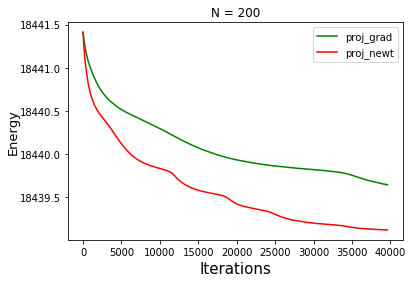

In [41]:
p=2*N0
q=-1
plt.plot(range(len(energiesG[p:q])), energiesG[p:q], c = 'g', label='proj_grad')
plt.plot(range(len(energiesN[p:q])), energiesN[p:q], c = 'r', label='proj_newt')
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Energy", fontsize = 13, labelpad = -0.5)
plt.legend(fontsize = 10)
plt.title("N = "+str(N0))
plt.savefig('Grad_vs_Newton_max_grad_'+str(N0), dpi = 300)
plt.show()

In [44]:
8.5*(5**3)/60.0

17.708333333333332

In [42]:
with open('../energies&points/Grad&Newton_energies&points_N0_'+str(N0), 'wb') as f:
    pickle.dump(energiesG, f)
    pickle.dump(pointsG, f)
    pickle.dump(energiesN, f)
    pickle.dump(pointsN, f)

# First order method

### Compare different types of coordinate choice

In [110]:
N0 = 500
Maxiter = 1000
s0 = 1

In [111]:
%%time
opt1 = BestOptimizer(N = N0, s = s0, accelerated=False, idx_choice = 'cyclic', maxiter = Maxiter, init_type = 'generalized_spiral')
energies1, points1 = opt1.Gradient_descent()
print('min_energy: ', energies1[-1])


min_energy:  118841.28791641400312
CPU times: user 32.4 s, sys: 180 ms, total: 32.6 s
Wall time: 32.5 s


In [112]:
%%time
opt2 = BestOptimizer(N = N0, s = s0, accelerated=False, idx_choice = 'max_grad', maxiter = Maxiter, init_type = 'generalized_spiral')
energies2, points2 = opt2.Gradient_descent()
print('min_energy: ', energies2[-1])


min_energy:  118838.455248187310644
CPU times: user 33.8 s, sys: 207 ms, total: 34 s
Wall time: 33.9 s


In [113]:
%%time
opt3 = BestOptimizer(N = N0, s = s0, accelerated=False,idx_choice = 'prob_grad', maxiter = Maxiter, init_type = 'generalized_spiral')
energies3, points3 = opt3.Gradient_descent()
print('min_energy: ', energies3[-1])


min_energy:  118838.74504542621435
CPU times: user 35 s, sys: 241 ms, total: 35.3 s
Wall time: 35.3 s


118841.28791641400312
118838.455248187310644
118838.74504542621435


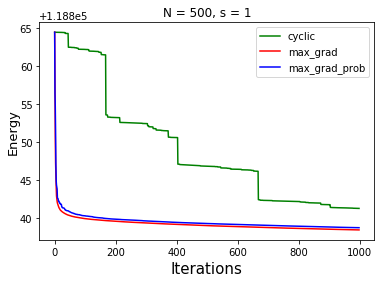

In [114]:
p = 0
q = -1
plt.plot(range(len(energies1[p:q])), energies1[p:q], c = 'g', label = 'cyclic')
plt.plot(range(len(energies2[p:q])), energies2[p:q], c = 'r', label = 'max_grad')
plt.plot(range(len(energies3[p:q])), energies3[p:q], c = 'b', label = 'max_grad_prob')
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Energy", fontsize = 13, labelpad = -0.5)
plt.legend(fontsize = 10)
plt.title("N = "+str(N0)+', s = '+str(s0))
plt.savefig('Point_choice_early_'+str(N0)+'_s_'+str(s0), dpi = 300)
print(energies1[-1])
print(energies2[-1])
print(energies3[-1])

### Large N test

In [4]:
N0 = 100
Maxiter = N0**2
s0 = 1

In [5]:
%%time
opt100 = BestOptimizer(N = N0, s = s0, accelerated=False, idx_choice = 'max_grad', maxiter = Maxiter, init_type = 'generalized_spiral')
energies100, points100 = opt100.Gradient_descent()
print('min_energy: ', energies100[-1])


min_energy:  4448.4926375153463596
CPU times: user 40.8 s, sys: 150 ms, total: 41 s
Wall time: 41 s


4448.4926375153463596


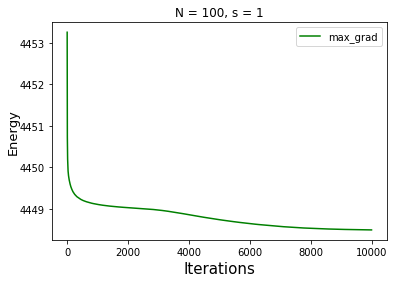

In [6]:
p = 0
q = -1
plt.plot(range(len(energies100[p:q])), energies100[p:q], c = 'g', label = 'max_grad')
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Energy", fontsize = 13, labelpad = -0.5)
plt.legend(fontsize = 10)
plt.title("N = "+str(N0)+', s = '+str(s0))
plt.savefig('Large_N_test'+str(N0)+'_s_'+str(s0), dpi = 300)
print(energies100[-1])

In [8]:
N0 = 470
Maxiter = N0**2
s0 = 1

In [9]:
%%time
opt470 = BestOptimizer(N = N0, s = s0, accelerated=False, idx_choice = 'max_grad', maxiter = Maxiter, init_type = 'generalized_spiral')
energies470, points470 = opt470.Gradient_descent()
print('min_energy: ', energies470[-1])


min_energy:  104825.39820461079944
CPU times: user 1h 9min 8s, sys: 19.3 s, total: 1h 9min 27s
Wall time: 1h 9min 28s


104825.39820461079944


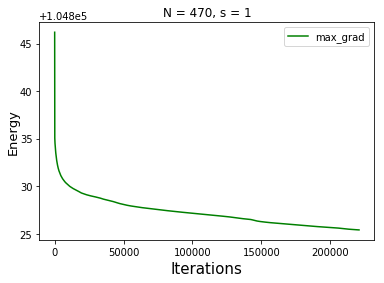

In [10]:
p = 0
q = -1
plt.plot(range(len(energies470[p:q])), energies470[p:q], c = 'g', label = 'max_grad')
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Energy", fontsize = 13, labelpad = -0.5)
plt.legend(fontsize = 10)
plt.title("N = "+str(N0)+', s = '+str(s0))
plt.savefig('Large_N_test'+str(N0)+'_s_'+str(s0), dpi = 300)
print(energies470[-1])

In [16]:
#with open('../energies&points/Grad_energies_470', 'wb') as f:
    pickle.dump(energies470, f)
    pickle.dump(points470, f)

### Visualization with Voronoi diagrams

In [13]:
def plot_Voronoi(pointsXYZ):
    sv = SphericalVoronoi(pointsXYZ)

    sv.sort_vertices_of_regions()
    # generate plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # plot the unit sphere for reference (optional)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color='y', alpha=0.1)
    # plot generator points
    ax.scatter(pointsXYZ[:, 0], pointsXYZ[:, 1], pointsXYZ[:, 2], c='b', s = 2)
    # plot Voronoi vertices
    #ax.scatter(sv.vertices[:, 0], sv.vertices[:, 1], sv.vertices[:, 2], c='g')
    # indicate Voronoi regions (as Euclidean polygons)
    for region in sv.regions:
        random_color = colors.rgb2hex(np.random.rand(3))
        polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
        if len(sv.vertices[region]) == 3:
            polygon.set_color('pink')
        elif len(sv.vertices[region]) == 4:
            polygon.set_color('yellow')
        elif len(sv.vertices[region]) == 5:
            polygon.set_color('red')
        elif len(sv.vertices[region]) == 6:
            polygon.set_color('green')
        elif len(sv.vertices[region]) == 7:
            polygon.set_color('black')
        else:
            polygon.set_color(random_color)
        polygon.set_edgecolor('black')
        ax.add_collection3d(polygon)
    plt.show()

(200, 3)


<IPython.core.display.Javascript object>


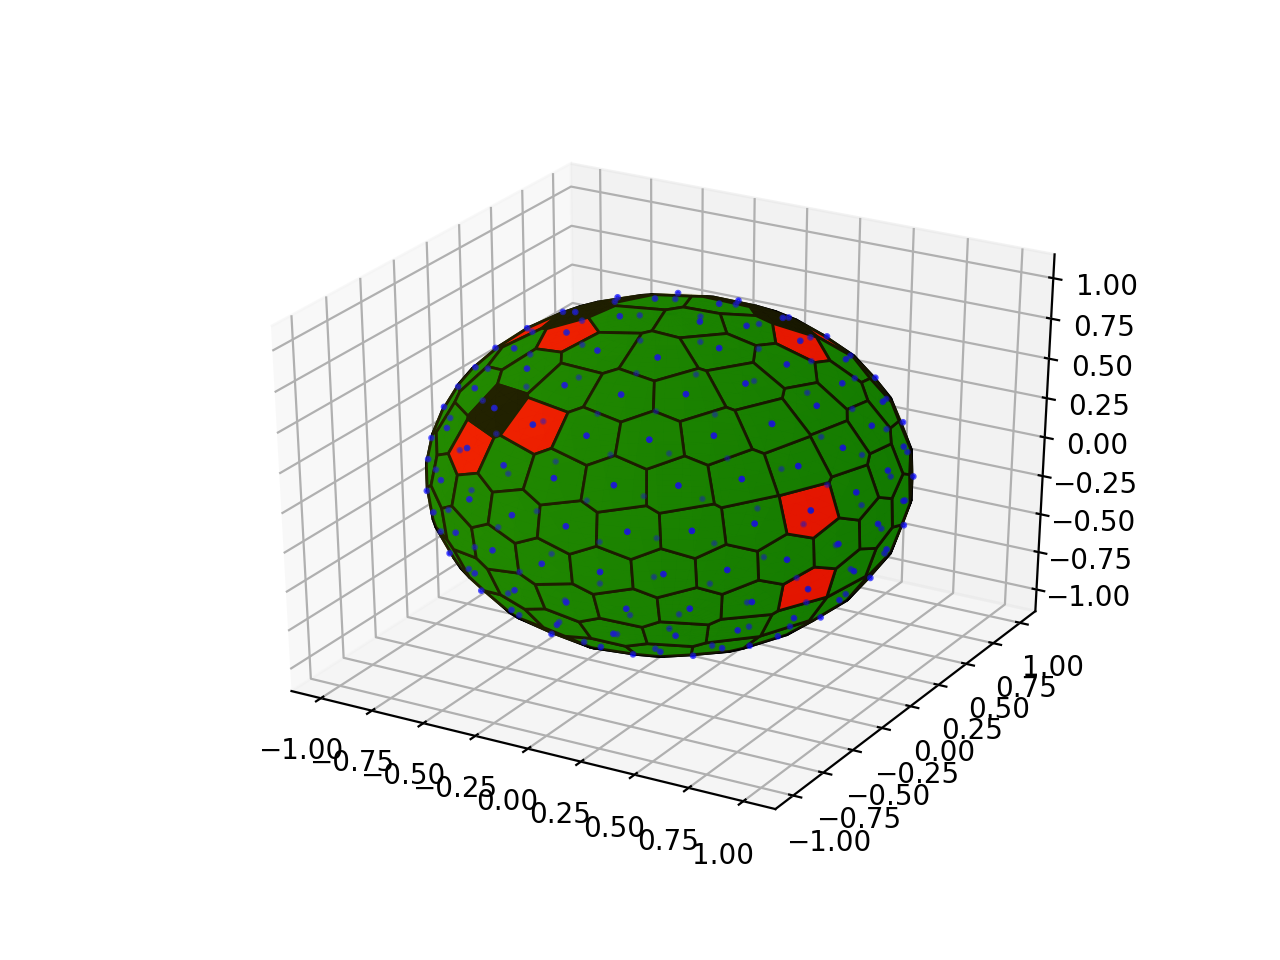

In [14]:
print(points1.shape)
plot_Voronoi(points1)

### Many local minima of Fekete problem

In [21]:
%%time
N0 = 10
Maxiter = 4000
number_of_runs=10
energies1=[]
for i in range(number_of_runs):
    opt1 = BestOptimizer(N = N0, maxiter = Maxiter, init_type = 'uniform')
    energies, points1, it1 = opt1.Gradient_descent()
    energies1.append(energies)
opt0 = BestOptimizer(N = N0, maxiter = Maxiter, init_type = 'generalized_spiral')
energies0, points0, it0 = opt0.Gradient_descent()

CPU times: user 27.6 s, sys: 58 ms, total: 27.7 s
Wall time: 27.6 s


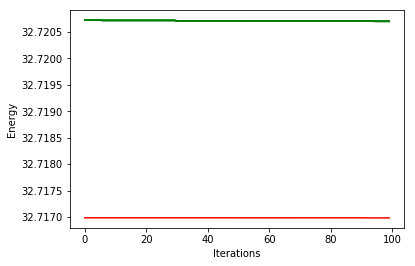

In [22]:
q = 100
for i in range(number_of_runs):
    plt.plot(range(len(energies1[i][-q:])), energies1[i][-q:], c = 'g', alpha = 0.5)
    
plt.plot(range(len(energies0[-q:])), energies0[-q:], c = 'r')
plt.ylabel("Energy")
plt.xlabel("Iterations")
#plt.ylim((30.0,40.0))
plt.savefig("discrete_energy_levels")

Check of linear convergence necessary conditions

### Distribution of points by distance

In [212]:
p = []
for i in range(972):
    p.append(np.sort(opt0.pairwise[i])[1])

(array([  2.,   2.,  24.,  34.,  23.,  23.,  17.,  26.,  47.,  54.,  56.,
         97., 115., 106., 109.,  69.,  76.,  59.,  25.,   8.]),
 array([0.10841672, 0.10909407, 0.10977142, 0.11044877, 0.11112612,
        0.11180347, 0.11248082, 0.11315817, 0.11383552, 0.11451287,
        0.11519022, 0.11586757, 0.11654492, 0.11722227, 0.11789962,
        0.11857697, 0.11925432, 0.11993167, 0.12060902, 0.12128637,
        0.12196372]),
 <a list of 20 Patch objects>)

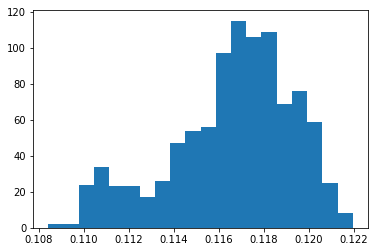

In [223]:
plt.hist(p, bins = 20)

### Linear execution time

In [23]:
%%time
Maxiter = 1000
times = []
Ns = list(range(10, 1500, 500))
for N0 in Ns:
    start = time.time()
    opt1 = BestOptimizer(N = N0, maxiter = Maxiter, it_change=Maxiter, init_type = 'generalized_spiral')
    energies1, points1, it1 = opt1.Gradient_descent()
    end = time.time()
    times.append(end-start)

CPU times: user 1min 48s, sys: 773 ms, total: 1min 49s
Wall time: 1min 49s


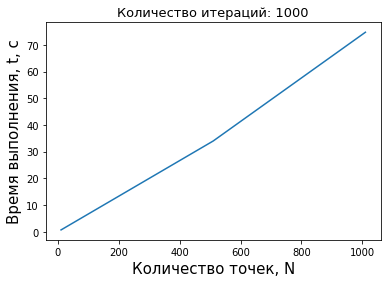

In [24]:
plt.plot(Ns, times)
plt.xlabel("Количество точек, N", size =15)
plt.ylabel("Время выполнения, t, с", size = 15)
plt.title("Количество итераций: 1000", size = 13)
plt.show()
#plt.savefig("linear_exec_time.png", dpi= 300)

### Table of results 1 order method

In [34]:
%%time
maxN = 50
Ns = []
min_energies = []
iter_stops = []
times = []
for N0 in range(2, maxN+1):
    Maxiter = 5000*N0
    start = time.time()
    opt = BestOptimizer(N = N0, maxiter = Maxiter, init_type = 'uniform')
    energies, points, it_stop = opt.Gradient_descent()
    end = time.time()
    times.append(end-start)
    Ns.append(N0)
    min_energies.append(energies[-1])
    iter_stops.append(it_stop)

CPU times: user 919 ms, sys: 14.2 ms, total: 933 ms
Wall time: 935 ms


In [35]:
print(Ns)
print(min_energies)
print(iter_stops)
print(times)

[2, 3, 4, 5]
[0.500000000000000111, 1.732050807568876305, 3.674234614174766378, 6.474691494688243232]
[49, 76, 107, 2494]
[0.01985907554626465, 0.021759986877441406, 0.031000852584838867, 0.8622698783874512]


In [45]:
data=pd.read_csv('best_known.txt', usecols=['N', 'best_energy'])

In [ ]:
%%time
Ns = data["N"].values[0:49]
NsG=[]
min_energiesG = []
iter_stopsG = []
timesG = []
tang_grads_G=[]
for N0 in Ns:
    Maxiter = 150*N0*N0
    start = time.time()
    opt = BestOptimizer(N = N0, maxiter = Maxiter, idx_choice = 'max_grad', init_type = 'generalized_spiral')
    energies, points = opt.Gradient_descent()
    end = time.time()
    timesG.append(end-start)
    NsG.append(N0)
    min_energiesG.append(energies[-1])
    iter_stopsG.append(opt.it+1)
    tang_grads_G.append(sum(opt.tangent_grad_lengths))

In [ ]:
%%time
Ns = data["N"].values[0:49]
NsN=[]
min_energiesN = []
iter_stopsN = []
timesN = []
tang_grads_N=[]
for N0 in Ns:
    Maxiter = 150*N0*N0
    start = time.time()
    opt = BestOptimizer(N = N0, maxiter = Maxiter, idx_choice = 'max_grad', it_change=2*N0, init_type = 'generalized_spiral')
    energies, points = opt.Newton()
    end = time.time()
    timesN.append(end-start)
    NsN.append(N0)
    min_energiesN.append(energies[-1])
    iter_stopsN.append(opt.it+1)
    tang_grads_N.append(sum(opt.tangent_grad_lengths))

In [ ]:
pd.set_option("display.precision", 9)
res = {"N" : NsG, "Известный минимум": data['best_energy'][0:49], "Минимум (метод 1)" : min_energiesG, "Минимум (метод 2)" : min_energiesN, "Итераций (1)" : iter_stopsG, "Итераций (2)" : iter_stopsN, "Время (1)" : np.array(timesG).round(2), "Время (2)" : np.array(timesN).round(2)}
df = pd.DataFrame.from_dict(res)
df

In [64]:
#df47_50=df

In [ ]:
s = df.to_latex(index=False)
with open("Latex_table_uniform.txt", "w") as text_file:
    text_file.write(s)